<a href="https://colab.research.google.com/github/snehasaini21/python-and-ml-assignment-1/blob/main/TF_IDF_Toxic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to your ZIP file in Google Drive
zip_path = '/content/drive/MyDrive/toxic_data.zip'  # 🔁 Update this
extract_path = '/content/toxic_data'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List extracted files
os.listdir(extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['train.csv.zip',
 'sample_submission.csv.zip',
 'test_labels.csv.zip',
 'test.csv.zip']

In [ ]:
import pandas as pd

train_df = pd.read_csv(f'{extract_path}/train.csv.zip')
test_df = pd.read_csv(f'{extract_path}/test.csv.zip')
test_labels_df = pd.read_csv(f'{extract_path}/test_labels.csv.zip')

# Preview
train_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['comment_text'] = train_df['comment_text'].apply(clean_text)
test_df['comment_text'] = test_df['comment_text'].apply(clean_text)


In [ ]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_df['num_labels'] = train_df[label_cols].sum(axis=1)
print(train_df[label_cols].sum())

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


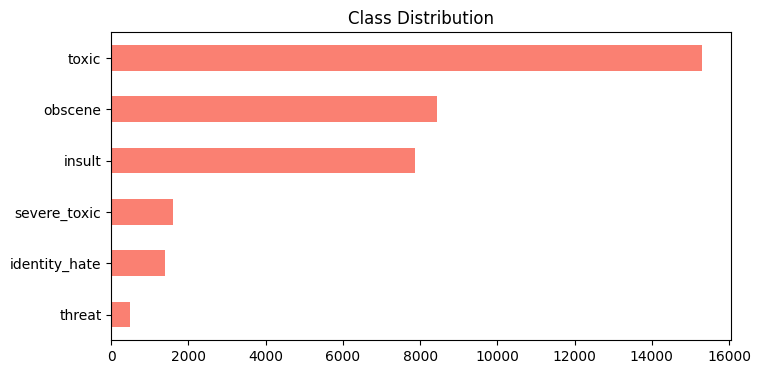

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
train_df[label_cols].sum().sort_values().plot(kind='barh', color='salmon')
plt.title("Class Distribution")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train = vectorizer.fit_transform(train_df['comment_text'])
X_test = vectorizer.transform(test_df['comment_text'])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_train = train_df[labels]

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
model.fit(X_train, y_train)


OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [ ]:
predictions = model.predict(X_test)

pred_df = pd.DataFrame(predictions, columns=labels)
pred_df.insert(0, 'id', test_df['id'])

print(pred_df.head())


                 id  toxic  severe_toxic  obscene  threat  insult  \
0  00001cee341fdb12      1             0        1       0       1   
1  0000247867823ef7      0             0        0       0       0   
2  00013b17ad220c46      0             0        0       0       0   
3  00017563c3f7919a      0             0        0       0       0   
4  00017695ad8997eb      0             0        0       0       0   

   identity_hate  
0              0  
1              0  
2              0  
3              0  
4              0  


In [ ]:
from sklearn.metrics import classification_report

# Filter out test rows with valid labels only (some are -1)
valid_test_labels = test_labels_df[test_labels_df[labels].min(axis=1) >= 0]
valid_test_data = test_df.merge(valid_test_labels, on='id')
X_eval = vectorizer.transform(valid_test_data['comment_text'])
y_true = valid_test_labels[labels]
y_pred = model.predict(X_eval)

print(classification_report(y_true, y_pred, target_names=labels))


               precision    recall  f1-score   support

        toxic       0.64      0.71      0.68      6090
 severe_toxic       0.40      0.33      0.36       367
      obscene       0.74      0.62      0.67      3691
       threat       0.39      0.22      0.28       211
       insult       0.73      0.51      0.60      3427
identity_hate       0.67      0.24      0.36       712

    micro avg       0.67      0.60      0.64     14498
    macro avg       0.60      0.44      0.49     14498
 weighted avg       0.68      0.60      0.63     14498
  samples avg       0.06      0.06      0.06     14498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_eval)

print("Random Forest Performance:")
print(classification_report(y_true, y_pred_rf, target_names=label_cols))

Random Forest Performance:
               precision    recall  f1-score   support

        toxic       0.55      0.81      0.66      6090
 severe_toxic       0.23      0.05      0.08       367
      obscene       0.59      0.72      0.65      3691
       threat       0.14      0.03      0.05       211
       insult       0.58      0.60      0.59      3427
identity_hate       0.67      0.19      0.29       712

    micro avg       0.56      0.68      0.62     14498
    macro avg       0.46      0.40      0.39     14498
 weighted avg       0.56      0.68      0.60     14498
  samples avg       0.07      0.07      0.06     14498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
xgb = MultiOutputClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1))
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_eval)

print("XGBoost Performance:")
print(classification_report(y_true, y_pred_xgb, target_names=label_cols))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:37:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:39:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:40:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:41:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:41:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Performance:
               precision    recall  f1-score   support

        toxic       0.64      0.68      0.66      6090
 severe_toxic       0.40      0.30      0.35       367
      obscene       0.66      0.67      0.67      3691
       threat       0.42      0.27      0.33       211
       insult       0.69      0.55      0.61      3427
identity_hate       0.68      0.35      0.46       712

    micro avg       0.65      0.61      0.63     14498
    macro avg       0.58      0.47      0.51     14498
 weighted avg       0.65      0.61      0.63     14498
  samples avg       0.06      0.06      0.06     14498



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
